In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import random
import tensorflow.keras.utils as utils
import pydot
from tensorflow.keras import regularizers
from tensorflow.keras import layers

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_gpu_available()
!python --version

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11116961063764041285
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17131534441593438532
physical_device_desc: "device: XLA_CPU device"
]
2.3.1
Num GPUs Available:  0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
/bin/bash: python: command not found


In [3]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon #multiplies with std

In [4]:
dataset_dir = "./Datasets/energydata_complete.csv"

In [5]:
df = pd.read_csv(dataset_dir, index_col=0)
df = df.fillna(df.mean())
df.head(10)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.890000,47.596667,19.20,44.790000,19.79,44.730000,19.000000,45.566667,...,17.033333,45.53,6.600000,733.500000,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.890000,46.693333,19.20,44.722500,19.79,44.790000,19.000000,45.992500,...,17.066667,45.56,6.483333,733.600000,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.890000,46.300000,19.20,44.626667,19.79,44.933333,18.926667,45.890000,...,17.000000,45.50,6.366667,733.700000,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
2016-01-11 17:30:00,50,40,19.890000,46.066667,19.20,44.590000,19.79,45.000000,18.890000,45.723333,...,17.000000,45.40,6.250000,733.800000,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
2016-01-11 17:40:00,60,40,19.890000,46.333333,19.20,44.530000,19.79,45.000000,18.890000,45.530000,...,17.000000,45.40,6.133333,733.900000,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
2016-01-11 17:50:00,50,40,19.890000,46.026667,19.20,44.500000,19.79,44.933333,18.890000,45.730000,...,17.000000,45.29,6.016667,734.000000,92.000000,5.333333,43.833333,4.800000,44.919484,44.919484
2016-01-11 18:00:00,60,50,19.890000,45.766667,19.20,44.500000,19.79,44.900000,18.890000,45.790000,...,17.000000,45.29,5.900000,734.100000,92.000000,5.000000,40.000000,4.700000,47.233763,47.233763
2016-01-11 18:10:00,60,50,19.856667,45.560000,19.20,44.500000,19.73,44.900000,18.890000,45.863333,...,17.000000,45.29,5.916667,734.166667,91.833333,5.166667,40.000000,4.683333,33.039890,33.039890
2016-01-11 18:20:00,60,40,19.790000,45.597500,19.20,44.433333,19.73,44.790000,18.890000,45.790000,...,17.000000,45.29,5.933333,734.233333,91.666667,5.333333,40.000000,4.666667,31.455702,31.455702


array([[<AxesSubplot:title={'center':'Appliances'}>]], dtype=object)

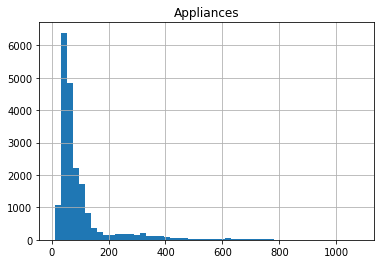

In [6]:
df.hist(column="Appliances", bins=50)

In [7]:
df.isnull().values.any()

False

In [8]:
df = df.sample(frac=1, random_state=41)

In [9]:
col_num = len(df.columns)
row_num = len(df.index)
print("Number of columns is: {} and number of rows is: {}".format(col_num, row_num))

Number of columns is: 28 and number of rows is: 19735


In [10]:
trainx = df.iloc[:int(0.8*row_num), 1:(col_num-2)]
trainy = df.iloc[:int(0.8*row_num), 0]

testx = df.iloc[int(0.8*row_num):, 1:(col_num-2)]
testy = df.iloc[int(0.8*row_num):, 0]

In [11]:
scaler = StandardScaler()
trainx_scaled = pd.DataFrame(scaler.fit_transform(trainx), columns = trainx.columns, index = trainx.index)
textx_scaled = pd.DataFrame(scaler.transform(testx), columns = testx.columns, index = testx.index)

In [12]:
group_A_train_x_op = trainx_scaled.iloc[:,[0,19,20,21,22,23,24]] 
group_B_train_x_op = trainx_scaled.iloc[:,[1,2,3,4,5,6,7,8,9,10]]
group_C_train_x_op = trainx_scaled.iloc[:,[11,12,13,14,15,16,17,18]]

group_A_test_x_op = textx_scaled.iloc[:,[0,19,20,21,22,23,24]]
group_B_test_x_op = textx_scaled.iloc[:,[1,2,3,4,5,6,7,8,9,10]]
group_C_test_x_op = textx_scaled.iloc[:,[11,12,13,14,15,16,17,18]]

In [13]:
size_inp_a = len(group_A_train_x_op.columns)
size_inp_b = len(group_B_train_x_op.columns)
size_inp_c = len(group_C_train_x_op.columns)

In [14]:
def get_MICS_model(inp_sizeA, inp_sizeB, inp_sizeC, use_encoders, drop_out, hidden_num = 4, hidden_size=32):
    inputs_A = keras.layers.Input(shape=(inp_sizeA), name="input_A")
    inputs_B = keras.layers.Input(shape=(inp_sizeB), name="input_B")
    inputs_C = keras.layers.Input(shape=(inp_sizeC), name="input_C")
    
    #If encoders are not to be used, inputs will be directly given to global model
    
    if use_encoders == True:
        encoder_A = get_encoder_model(inp_sizeA)
        encoder_B = get_encoder_model(inp_sizeB)
        encoder_C = get_encoder_model(inp_sizeC)
    
        global_inp_A = encoder_A(inputs_A)
        global_inp_B = encoder_B(inputs_B)
        global_inp_C = encoder_C(inputs_C)

        global_inp = keras.layers.concatenate([global_inp_A, global_inp_B, global_inp_C])
    else:
        global_inp = keras.layers.concatenate([inputs_A, inputs_A, inputs_A])
        
    h = keras.layers.Dense(hidden_size, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3))(global_inp)
    h = keras.layers.Dropout(drop_out)(h)
    for hidden in range(hidden_num):
        h = keras.layers.Dense(hidden_size, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3))(h)
        h = keras.layers.Dropout(drop_out)(h) 

    outputs = keras.layers.Dense(1, activation="relu")(h)    
    return keras.Model(inputs=[inputs_A, inputs_B, inputs_C], outputs = outputs)

def get_encoder_model(inp_size):
    inputs = layers.Input(shape=(inp_size))
    h1 = layers.Dense(10, activation="relu")(inputs)
    z_mean = layers.Dense(inp_size, name="z_mean")(h1)
    z_log_var = layers.Dense(inp_size, name="z_log_var")(h1)
    outputs = Sampling()([z_mean, z_log_var])
    return keras.Model(inputs,outputs)

In [15]:
i = 0
variational_list = []
while i<5:
    MICS_model = get_MICS_model(size_inp_a, size_inp_b, size_inp_c, use_encoders = True, drop_out = 0.25)
    callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50), 
            keras.callbacks.ReduceLROnPlateau("val_loss", factor = 0.8, patience=30,
                                             verbose = 2, mode = "auto", 
                                              min_lr = 1e-6)]
    MICS_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss=keras.losses.MeanSquaredError())
    history = MICS_model.fit(x = [group_A_train_x_op.values, group_B_train_x_op.values, group_C_train_x_op.values], y = trainy.values,  
                             validation_data = ([group_A_test_x_op.values, group_B_test_x_op.values, group_C_test_x_op.values], testy.values),
                             epochs=300, batch_size = 200, callbacks=callback)
    training_val_loss = history.history["val_loss"]
    best_row_index = np.argmin(training_val_loss)
    best_val_loss = training_val_loss[best_row_index]
    variational_list.append(best_val_loss)
    i = i+1

Epoch 1/300
79/79 [==============================] - 0s 5ms/step - loss: 12474.0723 - val_loss: 10291.2393
Epoch 2/300
79/79 [==============================] - 0s 3ms/step - loss: 10257.7080 - val_loss: 8385.8340
Epoch 3/300
79/79 [==============================] - 0s 2ms/step - loss: 9834.1475 - val_loss: 7832.1416
Epoch 4/300
79/79 [==============================] - 0s 2ms/step - loss: 9559.2285 - val_loss: 8141.3750
Epoch 5/300
79/79 [==============================] - 0s 2ms/step - loss: 9418.1543 - val_loss: 8472.8896
Epoch 6/300
79/79 [==============================] - 0s 2ms/step - loss: 9230.9795 - val_loss: 7756.6436
Epoch 7/300
79/79 [==============================] - 0s 2ms/step - loss: 9126.7217 - val_loss: 7874.2368
Epoch 8/300
79/79 [==============================] - 0s 2ms/step - loss: 9089.3125 - val_loss: 7905.1099
Epoch 9/300
79/79 [==============================] - 0s 2ms/step - loss: 9039.7734 - val_loss: 7806.7847
Epoch 10/300
79/79 [==============================] 

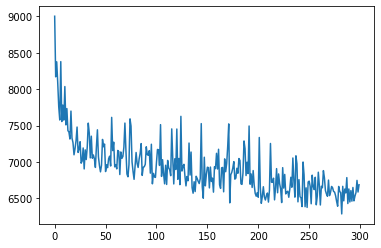

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history["val_loss"])

In [18]:
sum(variational_list)/len(variational_list)

6598.58095703125